In [1]:
from __future__ import print_function
from gensim.models import Word2Vec
import jieba
import numpy as np
from sklearn.manifold import TSNE
from copy import deepcopy

import matplotlib.pyplot as plt

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config))

%matplotlib inline

d:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 1. Word2Vec

In [2]:
def load_text(path):
    with open(path, 'rb') as f:
        text = f.read()
    text = text.decode('utf-8')
    
    return text

In [3]:
text = load_text('data/hongloumeng.txt')
print('corpus length:', len(text))

corpus length: 861117


In [8]:
def cut_sentence(text):
    start = 0
    i = 0
    sentences = []

    #punt_list = ',.!?:;~，。！？：；～'.decode('utf8')
    #punt_list = ',.!?:;~，．。！？：；～'.decode('utf-8')
    #punt_list = ('.!?~． 。！？～\n').decode('utf-8')
    punt_list = '.!?~． 。！？～\n'
    for word in text:
        if word in punt_list and token not in punt_list: #检查标点符号下一个字符是否还是标点
            sentences.append(text[start:i+1])
            start = i+1
            i += 1
        else:
            i += 1
            token = list(text[start:i+2]).pop() # 取下一个字符
    if start < len(text):
        sentences.append(text[start:])
    return sentences

## 1.1分词

In [9]:
sentences = cut_sentence(text)

In [10]:
tokenized_sentences = []
for sentence in sentences:
    tokenized_sentences.append([w for w in jieba.cut(sentence)])

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\mefly\AppData\Local\Temp\jieba.cache
Loading model cost 1.157 seconds.
Prefix dict has been built succesfully.


In [11]:
for w in tokenized_sentences[300]:
    print(w)

士隐
乃
读书
之
人
，
不
惯
生理
稼穑
等
事
，
勉强
支持
了
一二年
，
越觉
穷
了
下去
．


# 1.2 Word2Vec

In [12]:
model = Word2Vec(tokenized_sentences, size=50)

In [13]:
vocab = model.wv.vocab

In [14]:
model.save('model_50.model.bin')

In [15]:
for word, sim in model.wv.most_similar_cosmul(positive=[u'宝玉', u'黛玉'], negative=[u'宝钗']):
    print(word, sim)

贾琏 0.9171334505081177
鸳鸯 0.9125316739082336
薛姨妈 0.9064736366271973
凤姐 0.9059184789657593
林黛玉 0.905208945274353
紫鹃 0.9044192433357239
周瑞家 0.8991693258285522
香菱 0.898952841758728
赵姨娘 0.8935877084732056
贾母 0.8920637965202332


In [16]:
model.similarity(u'宝玉', u'黛玉')

d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.75646704

In [17]:
model.similarity(u'宝玉', u'宝钗')

d:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.82489145

## 1.3可视化

In [18]:
def plot_with_labels(embedded_vectors, labels):

    assert embedded_vectors.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize = (18, 18))
    for i, label in enumerate(labels):
        x, y = embedded_vectors[i, :]
        plt.scatter(x, y)
        plt.annotate(label, xy = (x, y), xytext = (5, 2), textcoords = 'offset points',ha = 'right',va = 'bottom')
    plt.show()

In [19]:
hongloumeng_embedding = Word2Vec.load('model_50.model.bin')

In [23]:
word_embedding = np.zeros((len(vocab) + 1, 50))
word_mapping = {}
for i, word in enumerate(hongloumeng_embedding.wv.vocab.keys()):
    word_embedding[i + 1] = hongloumeng_embedding.wv[word]
    word_mapping[word] = i + 1

In [25]:
type(word_mapping)

dict

In [28]:
index2word = dict((v, k) for k, v in word_mapping.items())

In [29]:
n_words_to_show = 300
start_index = 1000
tsne = TSNE(perplexity = 30, n_components = 2, init = 'pca', n_iter = 500)
reduced_word_vectors = tsne.fit_transform(word_embedding[start_index:start_index+n_words_to_show+1, :])
labels = [i for i in range(start_index, start_index+n_words_to_show+1)]

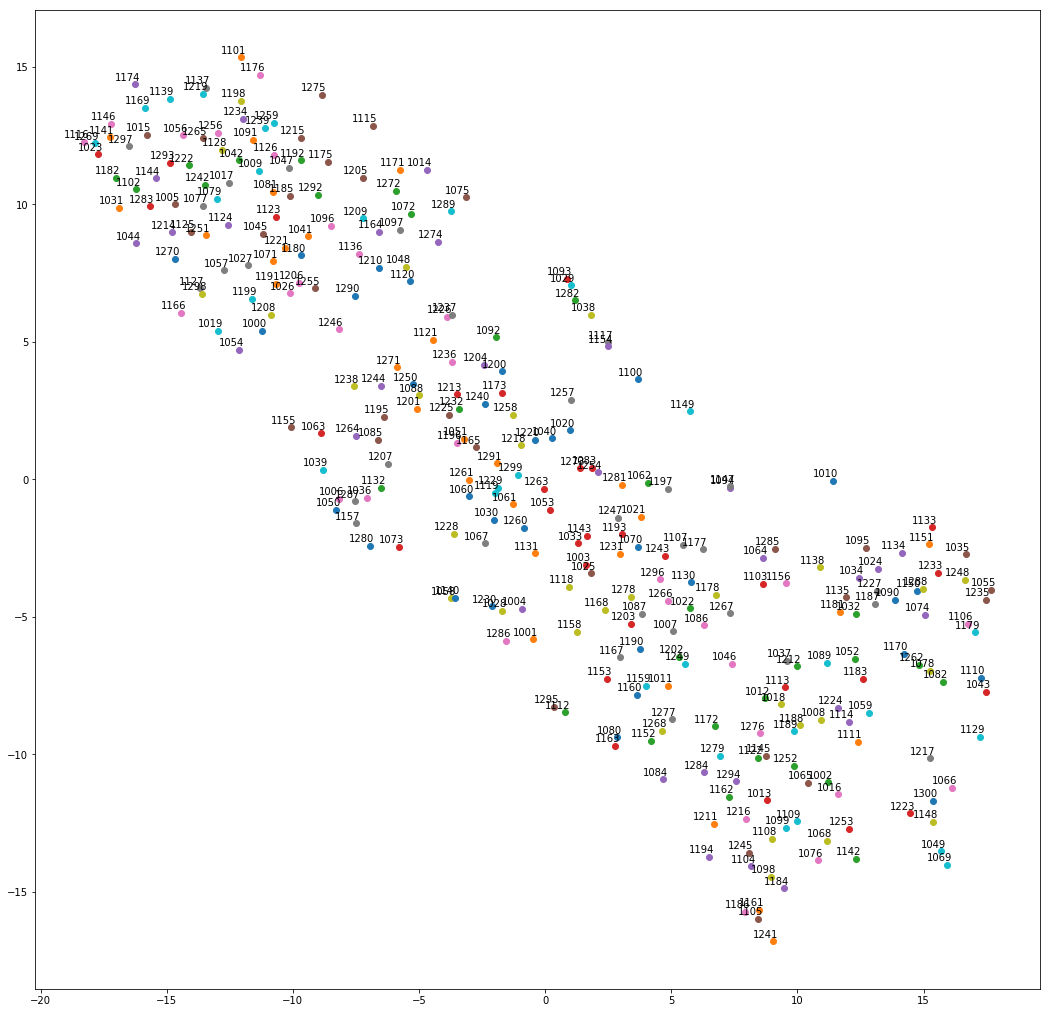

In [30]:
plot_with_labels(reduced_word_vectors, labels)

# 2. RNN 语言模型

In [31]:
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Embedding
from keras.optimizers import RMSprop

from sklearn.model_selection import train_test_split

import itertools
from collections import Counter

## 2.1 红楼梦的语言模型

In [32]:
word_counts = Counter(itertools.chain(*tokenized_sentences))

In [34]:
max_vocab = 20000
vocabulary = [x[0] for x in word_counts.most_common(max_vocab)]
vocabulary = list(sorted(vocabulary))
word2index = {x : i + 1 for i, x in enumerate(index2word)}
index2word = dict((v, k) for k, v in word2index.items())

In [35]:
test_size = int(len(tokenized_sentences)*0.3)

In [36]:
x = []
y = []
maxlen = 50
for s in tokenized_sentences[:-test_size]:
    tmp = []
    for i in range(min(len(s)-1, maxlen)):
        tmp.append(word2index[s[i]] if s[i] in word2index else 0)
        x.append(deepcopy(tmp))
        y.append(word2index[s[i+1]] if s[i+1] in word2index else 0)

In [37]:
assert len(x) == len(y)

In [38]:
x = pad_sequences(x, maxlen=maxlen, padding='pre')

In [39]:
x.shape

(387378, 50)

In [40]:
vocab_size = len(word2index)+1

In [41]:
y = np.array(y, dtype=np.int64)

In [42]:
Y_onehot = np.zeros((y.shape[0], vocab_size), dtype=np.bool)
for idx in range(y.shape[0]):
    Y_onehot[idx, y[idx]] = 1

In [43]:
train_x, valid_x, train_y, valid_y = train_test_split(x, Y_onehot, test_size=0.3, random_state=0)

In [44]:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=maxlen))
model.add(LSTM(50))
model.add(Dense(vocab_size))
model.add(Activation('softmax'))

In [45]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 10)            73900     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                12200     
_________________________________________________________________
dense_1 (Dense)              (None, 7390)              376890    
_________________________________________________________________
activation_1 (Activation)    (None, 7390)              0         
Total params: 462,990
Trainable params: 462,990
Non-trainable params: 0
_________________________________________________________________


In [46]:
rmsprop = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['accuracy'])

In [47]:
model.fit(train_x, train_y, validation_data=(valid_x, valid_y), epochs=1, verbose=True)

Train on 271164 samples, validate on 116214 samples
Epoch 1/1
271164/271164 [==============================] - 348s 1ms/step - loss: 0.0038 - acc: 0.9999 - val_loss: 1.1921e-07 - val_acc: 1.0000


In [48]:
model.fit(train_x, train_y, validation_data=(valid_x, valid_y), epochs=2, verbose=True)

Train on 271164 samples, validate on 116214 samples
Epoch 1/2
 19808/271164 [=>............................] - ETA: 4:45 - loss: 1.1921e-07 - acc: 1.0000

KeyboardInterrupt: 

## 2.2 测试语言模型

In [49]:
def compute_total_words(sentences):
    
    return np.sum([len(s) for s in sentences])

In [50]:
n_words_in_test = compute_total_words(tokenized_sentences[-test_size:])

In [51]:
n_words_in_test

179558

In [52]:
def compute_sentence_log_prob(model, sentence):
    test_x = []
    test_y = []
    tmp = []
    for i in range(len(sentence)-1):
        tmp.append(word_mapping[sentence[i]] if sentence[i] in word_mapping else 0)
        test_x.append(deepcopy(tmp))
        test_y.append(word_mapping[sentence[i+1]] if sentence[i+1] in word_mapping else 0)
    test_x = pad_sequences(test_x, maxlen=maxlen, padding='pre')
    test_y = np.array(test_y)
    test_y_pred = model.predict(test_x)
    probs = test_y_pred[(np.arange(test_x.shape[0]), test_y)]
    return np.sum(np.log2(probs))

In [53]:
compute_sentence_log_prob(model, tokenized_sentences[-3])

-146.00165

In [54]:
sum_log_prob = 0.0
for s in tokenized_sentences[-test_size:]:
    if len(s) <= 1:
        continue
    log_prob_s = compute_sentence_log_prob(model, s)
    sum_log_prob += log_prob_s
perplexity = 2**(-sum_log_prob/n_words_in_test)

In [55]:
perplexity

1993351.4426731912

# 3. RNN for POS tagging

## 3.1 Load data

In [56]:
from nltk.corpus import treebank
from keras.layers import TimeDistributed, Dropout

In [57]:
train_data = treebank.tagged_sents()

print(train_data[0])

[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]


In [58]:
word_mapping = {}
label_mapping = {}
i, j = 1, 1
for s in train_data:
    for t in s:
        if t[0] not in word_mapping:
            word_mapping[t[0]] = i
            i += 1
        if t[1] not in label_mapping:
            label_mapping[t[1]] = j
            j += 1

In [59]:
vocab_size = len(word_mapping) + 1
label_size = len(label_mapping) + 1

In [61]:
label_size

47

In [62]:
x = []
y = []
maxlen = -np.inf
for s in train_data:
    maxlen = max(len(s), maxlen)
    x.append([word_mapping[t[0]] for t in s])
    y.append([label_mapping[t[1]] for t in s])

In [63]:
x = pad_sequences(x, maxlen=maxlen, padding='pre')
y = pad_sequences(y, maxlen=maxlen, padding='pre')

In [64]:
y.shape

(3914, 271)

In [65]:
Y_onehot = np.zeros((y.shape[0], maxlen, label_size), dtype=np.bool)
for i in range(y.shape[0]):
    for j in range(maxlen):
        Y_onehot[i, j, y[i, j]] = 1

In [66]:
model = Sequential()
model.add(Embedding(vocab_size, 50, input_length=maxlen))
model.add(LSTM(50, return_sequences=True))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(TimeDistributed(Dropout(0.2)))
model.add(TimeDistributed(Dense(label_size, activation='softmax')))

In [68]:
rmsprop = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=rmsprop, metrics=['accuracy'])

In [71]:
train_x, valid_x, train_y, valid_y = train_test_split(x, Y_onehot, test_size=0.3, random_state=0)

In [72]:
model.fit(train_x, train_y, validation_data=(valid_x, valid_y), epochs=1, verbose=True)

Train on 2739 samples, validate on 1175 samples
Epoch 1/1
2739/2739 [==============================] - 20s 7ms/step - loss: 0.3148 - acc: 0.9256 - val_loss: 0.0986 - val_acc: 0.9713


In [74]:
test_s = "Today is a good day .".split()

In [75]:
test_x = pad_sequences([[word_mapping[w] for w in test_s]], maxlen=maxlen, padding='pre')

In [76]:
test_y_pred = model.predict(test_x)

In [78]:
index2label = dict((v, k) for k, v in label_mapping.items())

In [79]:
pred_label = []
for idx in np.argmax(test_y_pred, axis=2)[0]:
    if idx > 0:
        pred_label.append(index2label[idx])

In [80]:
pred_label

['NNP', 'VBZ', 'DT', 'NN', 'NN', '.']